In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile
import scipy
from scipy import signal
import math
import pandas as pd
from datetime import datetime

In [2]:
# Helper Functions
def GenerateUncorrelatedNoise(amp=1,dur=1,frate=10000):
    ts = np.arange(0,dur+1/frate,1/frate)
    result = np.random.uniform(-amp, amp, len(ts))
    return result,ts

def GenerateBrownianNoise(amp=1,dur=1,frate=10000):
    ts   = np.arange(0,dur+1/frate,1/frate)
    dsig = np.random.uniform(-1, 1, len(ts))
    sig  = np.cumsum(dsig)
    noise  = sig - np.mean(sig)
    noise /= np.amax(noise)
    noise *= amp
    return noise,ts

def GenerateGaussianNoise(mu = 0,amp = 1,dur = 1,frate = 10000):
    ts   = np.arange(0,dur+1/frate,1/frate)
    output = np.random.normal(mu, mu+amp, len(ts))
    return output,ts

def GenerateBetaNoise(signal,fq,Beta = 1):
    f = fq ** (Beta/2)
    f[0] = 1
    return signal/f

# Helper Function for converting waves to fft power spectrums back and forth
def make_spectrum(datain, ratein):
    n = len(datain)
   # d = 1 ./ ratein  # timestep
    # power spectral density
    hsout = np.fft.rfft(datain)
    # frequency spectrum
    freq = np.fft.rfftfreq(n, d=1./ratein)
    return hsout, freq

def make_wave(hsin):
    wave = np.fft.irfft(hsin)
    return wave

def integrated_spectrum(data):
    output = np.cumsum(data)
    output /= output[-1]
    return output

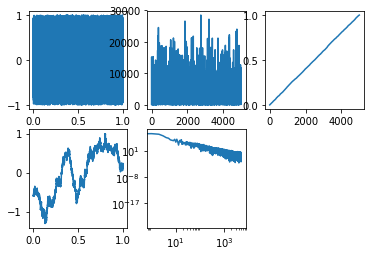

In [3]:
# Generate Uncorrelated/Brownian Noise and plot in both time/frequency domain
Vrange = 1 # (V)
tdur    = 1 # (s)
sr  = 10000 # (hz)

noise,ts   = GenerateUncorrelatedNoise(amp=Vrange,dur = tdur,frate = sr)
bnoise,bts = GenerateBrownianNoise(amp=Vrange,dur = tdur,frate = sr)

spec,fq  = make_spectrum(noise,sr)
power    = np.power(np.abs(spec),2)
intspc   = integrated_spectrum(power.copy())

bspec,bfq  = make_spectrum(bnoise,sr)
bpower     = np.power(np.abs(bspec),2)
bintspc    = integrated_spectrum(bpower.copy())

plt.subplot(231)
plt.plot(ts,noise)
plt.subplot(232)
plt.plot(fq,power)
plt.subplot(233)
plt.plot(fq,intspc)
plt.subplot(234)
plt.plot(bts,bnoise)
plt.subplot(235)
plt.plot(bfq,bpower)
plt.xscale("log")
plt.yscale("log")
plt.show()

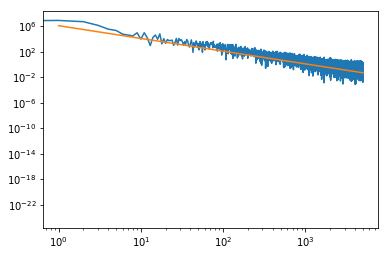

For Brownian noise, the power is proportional to 1/f^2


In [4]:
# Further exploring brownian noise
x = np.log(bfq[1:])
y = np.log(bpower[1:])
t = scipy.stats.linregress(x,y)
k = t.intercept
# Brown Noise power~frequency relationship P = k-2log(f) 
bpredpower = np.exp(k)/np.power(bfq[1:],2)
plt.plot(bfq,bpower)
plt.xscale("log")
plt.yscale("log")
plt.plot(bfq[1:],bpredpower)
plt.xscale("log")
plt.yscale("log")
plt.show()
print("For Brownian noise, the power is proportional to 1/f^2")

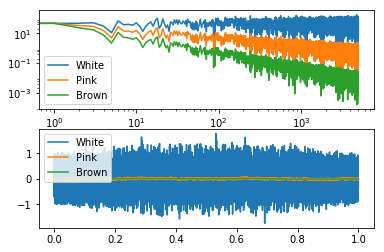

In [5]:
## Comparing While/Brown/Pink Noise
noise,ts = GenerateUncorrelatedNoise(amp=Vrange,dur = tdur,frate = sr)
spec,fq  = make_spectrum(noise,sr)
# White Noise power~frequency relationship P = k-[0]log(f) 
wspec = GenerateBetaNoise(spec.copy(),fq.copy(),Beta = 0) # White Noise
pspec = GenerateBetaNoise(spec.copy(),fq.copy(),Beta = 1) # Pink Noise
bspec = GenerateBetaNoise(spec.copy(),fq.copy(),Beta = 2) # Brown Noise
wnoise = make_wave(wspec)
pnoise = make_wave(pspec)
bnoise = make_wave(bspec)

plt.subplot(211)
plt.plot(fq,np.abs(wspec))
plt.plot(fq,np.abs(pspec))
plt.plot(fq,np.abs(bspec))
plt.xscale("log")
plt.yscale("log")
plt.legend(["White", "Pink","Brown"])
plt.subplot(212)
plt.plot(ts[1:],wnoise)
plt.plot(ts[1:],pnoise)
plt.plot(ts[1:],bnoise)
plt.legend(["White","Pink","Brown"])
plt.show()

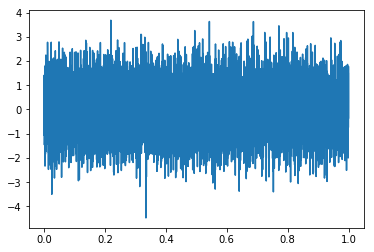

In [6]:
## Gaussian Noise
muk = 0
gnoise,gts = GenerateGaussianNoise(mu = muk,amp=Vrange,dur = tdur,frate = sr)
plt.plot(gts,gnoise)
plt.show()

In [7]:
# Load audio signal
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/SampleAudioFiles/'
fname = datafolder + '132736__ciccarelli__ocean-waves.wav'
rate, data = scipy.io.wavfile.read(fname)
# play audio signal
#sd.play(data,rate)

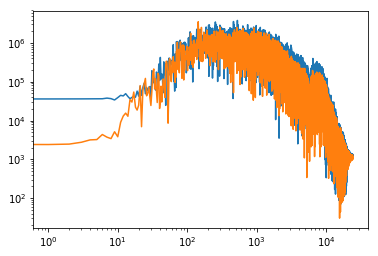

In [8]:
# Take 1s sample of audio signal at different points in time and Compare log x log spectrum
time = np.cumsum(np.full([1,len(data[:,0])],1/rate))
time[0] = 0
lidx1 = np.all([time >= 1.5, time <= 2.5],axis = 0) 
lidx2 = np.all([time >= 2.5, time <= 3.5],axis = 0) 
samp1 = data[lidx1,0]
samp2 = data[lidx2,0]

spec1,fq1 = make_spectrum(samp1.copy(), rate)
spec2,fq2 = make_spectrum(samp2.copy(), rate)

plt.plot(fq1,np.abs(spec1))
plt.plot(fq2,np.abs(spec2))
plt.xscale("log")
plt.yscale("log")
plt.show()

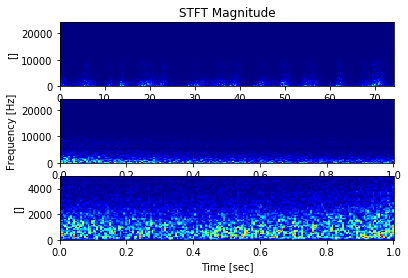

In [9]:
# Look at STFT across 2 samples and whole audio file
nsegLength = 512
f1, t1, Zxx1 = signal.stft(samp1, rate, nperseg=nsegLength)
f2, t2, Zxx2 = signal.stft(samp2, rate, nperseg=nsegLength)
f, t, Zxx = signal.stft(data[:,0], rate, nperseg=nsegLength)

plt.subplot(311)
plt.pcolormesh(t, f, np.abs(Zxx),cmap='jet')
plt.title('STFT Magnitude')
plt.ylabel([])
plt.xlabel([])
plt.subplot(312)
plt.pcolormesh(t1, f1, np.abs(Zxx1),cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel([])
plt.subplot(313)
plt.pcolormesh(t2, f2, np.abs(Zxx2),cmap='jet')
plt.ylabel([])
plt.xlabel('Time [sec]')
plt.ylim([0,5000])
plt.show()

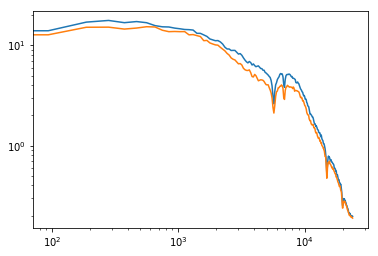

In [46]:
# Smooth out log log power spectrum to compare samples
steps     = Zxx1.shape[0]
freqrange = Zxx1.shape[1]
tempvals1 = np.zeros(steps)
tempvals2 = np.zeros(steps)
tempvals3 = np.zeros(steps)

for i in range(steps):
    tempvals1[i] = np.sqrt(sum(np.abs(Zxx1[i,:]))/freqrange)
    tempvals2[i] = np.sqrt(sum(np.abs(Zxx2[i,:]))/freqrange)

plt.plot(f1,tempvals1)
plt.plot(f2,tempvals2)
plt.xscale("log")
plt.yscale("log")
plt.show()

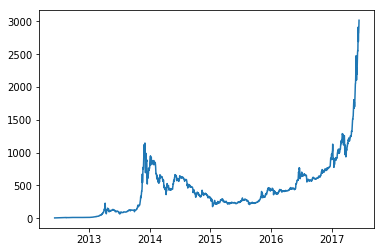

In [67]:
# Load Data File (BitCoine price IDX)
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/CSVFiles/'
fname = datafolder + 'coindesk-bpi-USD-close_data-2012-06-10_2017-06-12.csv'
df = pd.read_csv(fname, nrows=1828, parse_dates=[0])
prices = df.Price
dates  = pd.to_datetime(df.Date)
plt.plot(dates,prices)
plt.show()

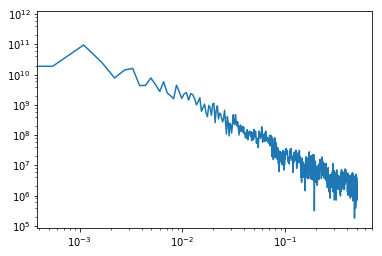

The slope (or Beta Value) =  -1.72036113666
This is close to Brown Noise (-2)


In [68]:
# Look at power spectrum
rate = 1 # day
spec,fq = make_spectrum(prices.copy(), rate)
x = fq
y = np.power(np.abs(spec),2)
plt.plot(x,y)
plt.xscale("log")
plt.yscale("log")
plt.show()
t = scipy.stats.linregress(np.log(x[1:]),np.log(y[1:]))
print("The slope (or Beta Value) = ", t.slope)
print("This is close to Brown Noise (-2)")